# Primer intento de ejercicio 1 (Si git nos permite)

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt
%matplotlib inline
from urllib.request import urlopen

In [21]:
# mygraph = nx.read_gml("/home/tnoten/Documentos/Redes TP 1/TP1/Datos/yeast_LIT.txt")
red_lit=nx.read_edgelist(urlopen("https://raw.githubusercontent.com/MarianoNicolini17/TP1/master/Datos/yeast_LIT.txt"))
red_bin=nx.read_edgelist(urlopen("https://raw.githubusercontent.com/MarianoNicolini17/TP1/master/Datos/yeast_Y2H.txt"))
red_prot=nx.read_edgelist(urlopen("https://raw.githubusercontent.com/MarianoNicolini17/TP1/master/Datos/yeast_AP-MS.txt"))

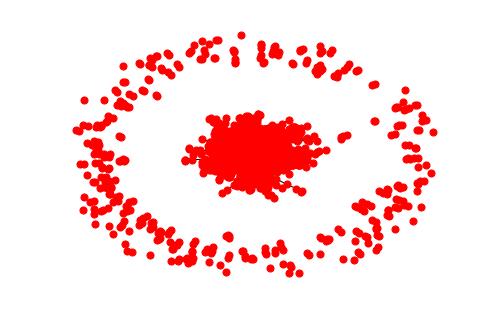

In [22]:
nx.draw(red_bin, node_size=50)

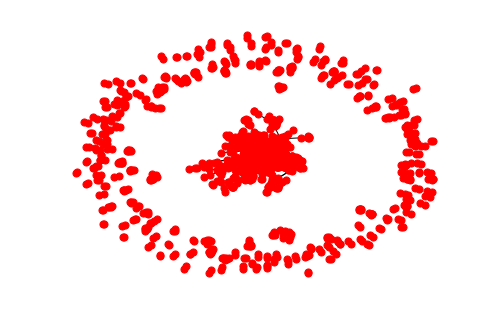

In [23]:
nx.draw(red_prot, node_size=50)

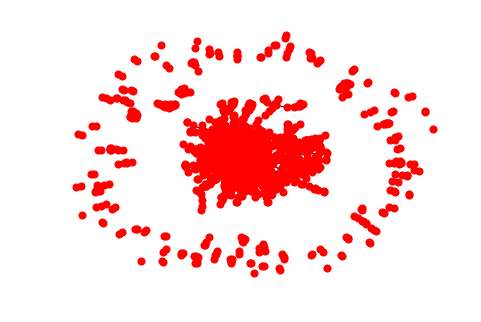

In [24]:
nx.draw(red_lit, node_size=50)

In [38]:
#d = list(red_prot.degree()).max()
d = [grado for nodo, grado in red_prot.degree()]
print(np.array(d).mean())

a = [2*i for i in range(5)]
print(a)

11.1837237978
[0, 2, 4, 6, 8]


In [48]:
def propiedades(red):
        
    caract = {}
    caract['Nodos'] = red.number_of_nodes()
    caract['Enlaces'] = red.number_of_edges()
    d = np.array([grado for nodo, grado in red.degree()])
    caract['Grado max'] = d.max()
    caract['Grado min'] = d.min()
    caract['Grado promedio'] = d.mean()
    caract['Densidad'] = caract['Enlaces'] / ((caract['Nodos']) * (caract['Nodos'] - 1) / 2)
    caract['Clustering medio'] = nx.average_clustering(red)
    caract['Transitividad'] = nx.transitivity(red)
    try:
        caract['Diametro'] = nx.diameter(red)
    except nx.NetworkXError:
        caract['Diametro'] = np.inf
        
    return caract

In [54]:
redes = [red_prot, red_bin, red_lit]
props = []

for red in redes:
    props.append(propiedades(red))

pd.DataFrame(props).index(['Red Proteica','Red Binaria', 'Red Literatura'])

TypeError: 'RangeIndex' object is not callable

In [10]:
f=open("/home/tnoten/Documentos/Redes TP 1/TP1/Datos/yeast_LIT.txt","r")

<_io.TextIOWrapper name='/home/tnoten/Documentos/Redes TP 1/TP1/Datos/yeast_LIT.txt' mode='r' encoding='UTF-8'>


In [33]:
from collections import defaultdict

def esDirigido(file):

    with open(file,"r") as f:
        vecinos = defaultdict(set)
        i = 0
        s = True
        for line in f:
            a = line.rstrip('\n').split('\t')
            v = a[0]
            w = a[1]
            vecinos[v].add(w)
            i += 1
            if v in vecinos[w] and  w!=v:
                return True
                # print(a)
                # print(i)
            elif v == w and s:
                print("Warning: No es un grafo simple")
                s = False
                # print(a)
                # print(i)
            
        return False

In [34]:
esDirigido("/home/tnoten/Documentos/Redes TP 1/TP1/Datos/yeast_LIT.txt")

False

In [3]:
#dat = urlopen("https://raw.githubusercontent.com/MarianoNicolini17/TP1/master/Datos/dolphins.gml")
red_delf = nx.read_gml(urlopen("https://raw.githubusercontent.com/MarianoNicolini17/TP1/master/Datos/dolphins.gml"))

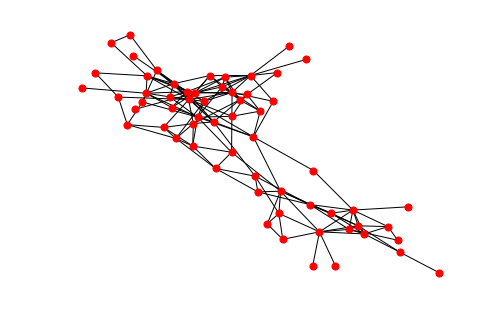

In [6]:
nx.draw(red_delf, node_size=50)

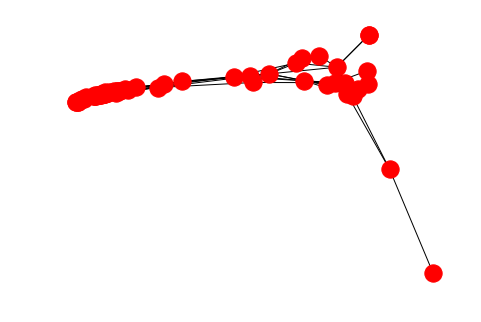

In [5]:
nx.draw_spectral(red_delf)


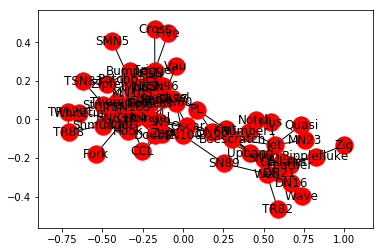

In [4]:
nx.draw_networkx(red_delf)

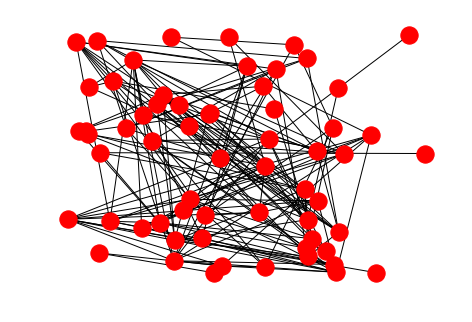

In [12]:
nx.draw_random(red_delf)

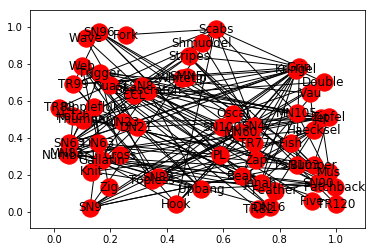

In [11]:
G=nx.path_graph(4)
pos=nx.random_layout(red_delf)
nx.draw_networkx(red_delf,pos)